(=theory)
# The Hierarchical Gaussian Filter
In this notebook, we are going to introduce the basic concepts on which the Hierarchical Gaussian Filter (HGF) is based. We introduce the main equations and illustrate some of the examples with Python code. We start with the generative model of the HGF, which can be seen as the structure creating the sensory inputs that the agent tries to use to produce behaviours. This can be seen as the process occurring in the environment. Next, we show how this model can be "inverted" and used by an agent to infer parameter values that generated the sensory inputs. From there, we discuss the notion of prediction error and how derivations of the model can be used to infer probability densities given observed behavioural outcomes.

## The generative model of the HGF

In this section we will use the two-level HGF as an example (see also the tutorial {ref}`continuous_hgf`). The generative model that underpine the continuous HGF can be seen as a generalisation of the [Gaussian Random Walk](https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk) (GRW). Put simply, a GRW generate a new observation $x_1^{(k)}$ at each time step $k$ from a normal distribution and using the previous observation $x_1^{(k-1)}$ such as:

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)}, \sigma^2)
$$

where $\sigma^2$ is the variance of the distribution. In the example below, we use $\sigma^2 = 1$ and $x_1^{(0)} = 0$.

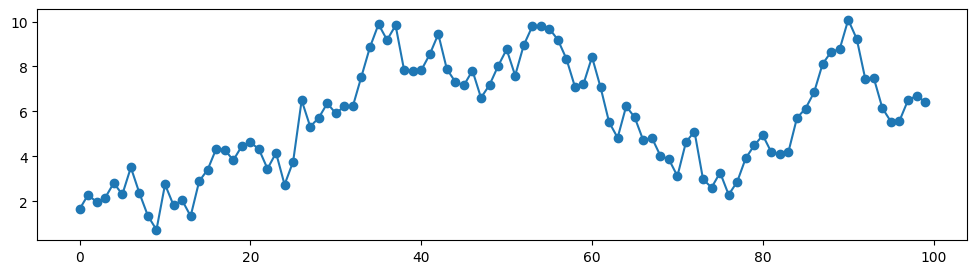

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# random walk
x_1 = np.cumsum(np.random.normal(loc=0, scale=1, size=100))

plt.figure(figsize=(12, 3))
plt.plot(x_1, "o-");

This simple process will be our first building block. Importantly here, the variability of the sensory input is constant across time: even if we don't know exactly in which direction the time series is going to move in the future, we know that is is unlikely to make certain kind of big jumps, which is controlled by the variance $\sigma^2$. The HGF generalize this idea by letting the variance $\sigma^2$ being controlled by another random walk, in a higher level of the hierarchie, which is defined as *volatility coupling* (see below). This lead us to the generative model of the HGF, which can be seen as a hierarchical Gaussian Random Walk, where (hidden) states of the world perform Gaussian random walks in time and produce outcomes which are perceived by an observer as inputs.

States can influence each other via volatility coupling or via value coupling.

In the classical 3-level binary HGF as presented in {cite:p}`2011:mathys`, the two states of interest, $x_2$ and $x_3$, are coupled to each other via volatility coupling, which means that for state $x_2$, the mean of the Gaussian random walk on trial $k$ is given by its previous value $x_2^{(k-1)}$, while the step size (or variance) depends on the current value of the higher level state, $x_3^{(k)}$:

$$
x_2^{(k)} \sim \mathcal{N}(x_2^{(k)} | x_2^{(k-1)}, \, f(x_3^{(k)})),
$$

where the exact dependency is of the form

$$
    f(x_3^{(k)}) = \exp(\kappa_2 x_3^{(k)} + \omega_2).
$$

However, a higher-level state can also have influence on a lower-level state by influencing its mean. In that case, the mean of the Gaussian random walk at one level is a function not only of its own previous value, but also the current value of the higher-level state (with step size either constant or a function of another state):

$$
    x_2^{(k)} \sim \mathcal{N}(x_2^{(k)} | x_2^{(k-1)} + \alpha_{4,2} x_4^{(k)}, \, \exp(\omega_2)),
$$

which means constant step size, or

$$
    x_2^{(k)} \sim \mathcal{N}(x_2^{(k)} | x_2^{(k-1)} + \alpha_{4,2} x_4^{(k)}, \, \exp(\kappa_2 x_3^{(k)} + \omega_2)).
$$

## Volatility vs. value coupling

In other words, any given state in the world can be modelled as having a volatility parent state, a value parent state, or both, or none (in which case it evolves as a Gaussian random walk around its previous value with fixed step size). Consequently, when inferring on the evolution of these states, the exact belief update equations (which include the computation of new predictions, posterior values, and prediction errors, and represent an approximate inversion of this generative model, see {cite:p}`2011:mathys` depend on the nature of the coupling of a given state with its parent and children states. In particular, the nodes that implement the belief updates will communicate with their value parents via value prediction errors, or **VAPE**s, and via volatility prediction errors, or **VOPE**s, with their volatility parents.

:::{figure-md} fig1
<img src="./images/genmod.svg" alt="fishy" class="bg-primary mb-1">

An example of a generative model of sensory inputs with six hidden states. Volatility coupling is depicted with dashed lines, value coupling with straight lines.
:::

In [](fig1) we have drawn an example setup with six different environmental states and one outcome. Here, we have denoted states that function as value parents for other states as $x_i$, and states that function as volatility parents as $\check{x}_i$. Volatility coupling is depicted by curvy arrows, value coupling by straight arrows, and observable outcomes are linked to their hidden states via double arrows.

For the example illustrated in [](fig1) the following equations describe the generative model:

$$
\begin{align}
u^{(k)} &\sim \mathcal{N}(u^{(k)} | x_1^{(k)}, \, \sigma_u) \\
x_1^{(k)}           &\sim \mathcal{N}(x_1^{(k)} | x_1^{(k-1)} + \alpha_{2,1} x_2^{(k)}, \, \exp(\kappa_1 \check{x}_1^{(k)} + \omega_1)) \\
\check{x}_1^{(k)}   &\sim \mathcal{N}(\check{x}_1^{(k)} | \check{x}_1^{(k-1)} + \alpha_{3,\check{1}} x_3^{(k)}, \, \exp(\omega_{\check{1}})) \\
x_2^{(k)}           &\sim \mathcal{N}(x_2^{(k)} | x_2^{(k-1)}, \, \exp(\kappa_2 \check{x}_2^{(k)} + \omega_2)) \\
\check{x}_2^{(k)}   &\sim \mathcal{N}(\check{x}_2^{(k)} | \check{x}_2^{(k-1)}, \, \exp(\omega_{\check{2}})) \\
x_3^{(k)}           &\sim \mathcal{N}(x_3^{(k)} | x_3^{(k-1)}, \, \exp(\kappa_3 \check{x}_3^{(k)} + \omega_3)) \\
\check{x}_3^{(k)}   &\sim \mathcal{N}(\check{x}_3^{(k)} | \check{x}_3^{(k-1)}, \, \exp(\omega_{\check{3}})) \\
\end{align}
$$

Note that in this example, all states that are value parents of other states (or outcomes) have their own volatility parent, while states that are volatility parents to other nodes either have a value parent (as state $\check{x}_1$), or no parents (as states $\check{x}_2$ and $\check{x}_3$). This is deliberately so, and we will see these two motifs - every state of a hierarchy has its own volatility estimation, and volatility states only have value parents - reappear in the following chapters.

## Belief updates in the HGF: Computations of nodes

In the approximate inversion of the generative model presented above, {cite:p}`2011:mathys` derived a set of simple, one-step update equations that represent changes in beliefs about the hidden states specified in the generative model. For each state, a belief is held (and updated for every new input) by the agent and described as a Gaussian distribution, fully characterized by its mean $\mu_i^{(k)}$ and its inverse variance, or precision, $\pi_i^{(k)}$ on a given trial $k$. We conceptualize each belief as a node in a network, where belief updates involve computations within nodes as well as message passing between nodes. The computations of any node within an experimental trial can be ordered in time as shown in the box:

> Node *i* at trial *k*
>
>(compute $\mathrm{prediction}^{(k)}_i$)  
>&larr; receive $\mathrm{PE}^{(k)}_{i-1}$ from $\mathrm{node}_{i-1}$
>
>UPDATE step  
>compute $\mathrm{posterior}^{(k)}_i$  
>*given:* $\mathrm{PE}^{(k)}_{i-1}$ and $\mathrm{prediction}^{(k)}_i$  
>&rarr; send $\mathrm{posterior}^{(k)}_i$ to $\mathrm{node}_{i-1}$
>
>PE step  
>compute $\mathrm{PE}^{(k)}_i$  
>*given:* $\mathrm{prediction}^{(k)}_i$ and $\mathrm{posterior}^{(k)}_i$  
>&rarr; send $\mathrm{PE}^{(k)}_i$ to $\mathrm{node}_{i+1}$  
>&larr; receive $\mathrm{posterior}^{(k)}_{i+1}$ from $\mathrm{node}_{i+1}$  
>
>PREDICTION step  
>compute $\mathrm{prediction}^{(k+1)}_i$  
>*given:* $\mathrm{posterior}^{(k)}_i$ and $\mathrm{posterior}^{(k)}_{i+1}$  

The exact computations in each step depend on the nature of the coupling (via **VAPE**s vs. **VOPE**s) with the parent and children nodes and will be outlined in the following two chapters.

Note that we have placed the **PREDICTION** step in the end of a trial. This is because usually, we think about the beginning of a trial as starting with receiving a new input, and of a prediction as being present before that input is received. However, in some variants of the HGF the prediction also depends on the time that has passed in between trials, which is something that can only be evaluated once the new input arrives - hence the additional computation of the (current) prediction in the beginning of the trial. Conceptually, it makes most sense to think of the prediction as happening continuously between trials. For implementational purposes, it is however most convenient to only compute the prediction once the new input (and with it its arrival time) enters. This ensures both that the posterior means of parent nodes have had enough time to be sent back to their children for preparation for the new input, and that the arrival time of the new input can be taken into account appropriately.


## Computations for VAPE coupling

The exact computations of the **UPDATE** depend on the nature of the coupling with the child node(s), while both the **PE step** and the **PREDICTION step** depend on the coupling with the parent node(s).

### Update Step

If Node~$i$ is the value parent of Node $i-1$, then the following update equations apply to Node~$i$:

$$
\begin{align}
\pi_i^{(k)} &= \hat{\pi}_i^{(k)} + \alpha_{i-1,i}^2 \hat{\pi}_{i-1}^{(k)}\\
\mu_i^{(k)} &= \hat{\mu}_i^{(k)} + \frac{\alpha_{i-1,i}^2 \hat{\pi}_{i-1}^{(k)}} {\alpha_{i-1,i}^2 \hat{\pi}_{i-1}^{(k)} + \hat{\pi}_{i}^{(k)}} \delta_{i-1}^{(k)}
\end{align}
$$

We note here that we can let the update of the precision happen first, and therefore use it for the update of the mean:

$$
\begin{align}
\pi_i^{(k)} &= \hat{\pi}_i^{(k)} + \alpha_{i-1,i}^2 \hat{\pi}_{i-1}^{(k)}\\
\mu_i^{(k)} &= \hat{\mu}_i^{(k)} + \frac{\alpha_{i-1,i}^2 \hat{\pi}_{i-1}^{(k)}} {\pi_i^{(k)}} \delta_{i-1}^{(k)}
\end{align}
$$

In sum, at the time of the update, Node~$i$ needs to have access to the following quantities:

* Its own predictions: $\hat{\mu}_i^{(k)}$, $\hat{\pi}_i^{(k)}$  
* Coupling strength: $\alpha_{i-1,i}$  
* From level below: $\delta_{i-1}^{(k)}$, $\hat{\pi}_{i-1}^{(k)}$  

All of these are available at the time of the update. Node~$i$ therefore only needs to receive the PE and the predicted precision from the level below to perform its update.

### Prediction Error Step

We will assume in the following, that Node~$i$ is the value child of Node $i+1$. Then the following quantities have to be sent up to Node $i+1$ (cf. necessary information from level below in a value parent):

* Predicted precision: $\hat{\pi}_{i}^{(k)}$
* Prediction error: $\delta_{i}^{(k)}$

Node~$i$ has already performed the **PREDICTION step** on the previous trial, so it has already computed the predicted precision of the current trial,~$\hat{\pi}_{i}^{(k)}$. Hence, in the **PE step**, it needs to perform only the following calculation:
$$
\begin{equation}
\delta_i^{(k)} = \mu_i^{(k)} - \hat{\mu}_i^{(k)}
\end{equation}
$$

### Prediction Step

Still assuming that Node~$i$ is the value child of Node $i+1$, the **PREDICTION step** consists of the following computations:

$$
\begin{align}
\hat{\mu}_i^{(k+1)} &= \mu_i^{(k)} + \alpha_{i,i+1} \mu_{i+1}^{(k)}\\
\hat{\pi}_i^{(k+1)} &= \frac{1}{\frac{1}{\pi_i^{(k)}} + \nu_i^{(k+1)} }
\end{align}
$$

with

$$
\begin{equation}
\nu_i^{(k+1)} = \exp(\omega_i).
\end{equation}
$$

Note that if Node~$i$ additionally has a **VOPE** parent node, the estimated volatility $\nu_i^{(k+1)}$ that enters the precision update would also depend on the posterior mean of that volatility parent (cf. **PREDICTION step** for **VOPE** coupling).

In general, the prediction of the mean will depend only on whether Node~$i$ has a value parent or not, whereas the prediction of the precision only depends on whether Node~$i$ has a volatility parent or not.

Thus, the **PREDICTION step** only depends on knowing the node's own posteriors and receiving the value parent's posterior in time before the new input arrives.


## Computations for VOPE coupling

As in the case of **VAPE** coupling, the exact computations of the **UPDATE step** depend on the nature of the coupling with the child node(s), while both the **PE step** and the **PREDICTION step** depend on the coupling with the parent node(s).

To describe the computations entailed by **VOPE** coupling, we will introduce two changes to the notation. First of all, we will express the volatility PE, or **VOPE**, as a function of the previously defined value PE, or **VAPE**. That means from now on, we will use the character $\delta_i$ only for **VAPE**s:

$$
\begin{equation}
\delta_i^{(k)} \equiv \delta_i^{(k, VAPE)} = \mu_i^{(k)} - \hat{\mu}_i^{(k)},
\end{equation}
$$

and introduce a new character $\Delta_i$ for **VOPE**s, which we define as

$$
\begin{equation}
  \begin{split}
    \Delta_i^{(k)} \equiv \delta_i^{(k, VOPE)} &= \frac{ \frac{1}{\pi_{i}^{(k)}} + (\mu_i^{(k)} - \hat{\mu}_i^{(k)})^2 }{ \frac{1}{\pi_{i}^{(k-1)}} + \nu_{i}^{(k)} } - 1 \\
    &= \hat{\pi}_i^{(k)} \left( \frac{1}{\pi_{i}^{(k)}} + (\mu_i^{(k)} - \hat{\mu}_i^{(k)})^2 \right) - 1 \\
    &= \hat{\pi}_i^{(k)} \left( \frac{1}{\pi_{i}^{(k)}} + (\delta_i^{(k)})^2 \right) - 1 \\
    &=  \frac{\hat{\pi}_i^{(k)}}{\pi_{i}^{(k)}} + \hat{\pi}_i^{(k)} (\delta_i^{(k)})^2 - 1. \\
  \end{split}
\end{equation}
$$

Note that from the first to the second line, we have used the following definition:

$$
\begin{equation*}
\hat{\pi}_{i-1}^{(k)} = \frac{1}{ \frac{1}{\pi_{i-1}^{(k-1)}} + \nu_{i-1}^{(k)} }.
\end{equation*}
$$

This ensures that a given node does not need to have access to the posterior precision from the level below: $\pi_{i-1}^{(k-1)}$, which facilitates implementation.

In sum, we are introducing a second prediction error unit $\Delta_i$ which is concerned with deviations from predicted uncertainty and is informed by value prediction errors and other estimates of uncertainty. It is this prediction error - a function of the unweighted (squared) value prediction error with a new precision weight - which communicates between a level's nodes and a level's volatility parent's nodes.

Second, we will introduce another quantity, which we term the (auxiliary) expected precision

$$
\begin{equation}
\gamma_i^{(k)} = \nu_i^{(k)} \hat{\pi}_i^{(k)},
\end{equation}
$$

which will be computed as part of the **PREDICTION step** and only serves to simplify the equations and the corresponding message passing.

### Update Step

If Node $i$ is the volatility parent of Node $i-1$, then the following update equations apply to Node $i$:

$$
\begin{align*}
\pi_i^{(k)} &= \hat{\pi}_i^{(k)}
+ \frac{1}{2}(\kappa_{i-1} \nu_{i-1}^{(k)} \hat{\pi}_{i-1}^{(k)})^2
* (1 + (1 - \frac{1}{\pi_{i-1}^{(k-1)} \nu_{i-1}^{(k)}})
\delta_{i-1}^{(k)})\\
&= \hat{\pi}_i^{(k)}
+ \frac{1}{2}(\kappa_{i-1} \nu_{i-1}^{(k)} \hat{\pi}_{i-1}^{(k)})^2
* (1 + (2 - \frac{1}{\hat{\pi}_{i-1}^{(k)} \nu_{i-1}^{(k)}})
\delta_{i-1}^{(k)})\\
\mu_i^{(k)} &= \hat{\mu}_i^{(k)}
+ \frac{1}{2}\kappa_{i-1} \nu_{i-1}^{(k)}
\frac{\hat{\pi}_{i-1}^{(k)}}{\pi_{i}^{(k)}} \delta_{i-1}^{(k)},
\end{align*}
$$

where we have again used the definition of the predicted precision $\hat{\pi}_{i-1}^{(k)}$ to derive an expression for the posterior precision from the previous trial $\pi_{i-1}^{(k-1)}$:

$$
\begin{align*}
\hat{\pi}_{i-1}^{(k)} &= \frac{1}{ \frac{1}{\pi_{i-1}^{(k-1)}} + \nu_{i-1}^{(k)} }\\
\Leftrightarrow \pi_{i-1}^{(k-1)} &= \frac{1}{ \frac{1}{\hat{\pi}_{i-1}^{(k)}} - \nu_{i-1}^{(k)} }.
\end{align*}
$$

With the changes from above, namely the definitions of the \textsf{VOPE} $\Delta_i$ and the expected precision $\gamma_i^{(k)}$, the update equations for the precision and the mean in volatility coupling simplify to:
\vspace{0.5cm}

$$
\begin{align}
\pi_i^{(k)} &= \hat{\pi}_i^{(k)}
+ \frac{1}{2} (\kappa_{i,i-1} \gamma_{i-1}^{(k)})^2
+ (\kappa_{i,i-1} \gamma_{i-1}^{(k)})^2 \Delta_{i-1}^{(k)}
- \frac{1}{2} \kappa_{i,i-1}^2 \gamma_{i-1}^{(k)} \Delta_{i-1}^{(k)}\\
\mu_i^{(k)} &= \hat{\mu}_i^{(k)}
+ \frac{1}{2} \frac{\kappa_{i,i-1} \gamma_{i-1}^{(k)}}{\pi_i^{(k)}} \Delta_{i-1}^{(k)}
\end{align}
$$

Therefore, at the time of the update, Node $i$ needs to have access to the following quantities:

* Its own predictions: $\hat{\mu}_i^{(k)}$, $\hat{\pi}_i^{(k)}$
* Coupling strength: $\kappa_{i,i-1}$
* From level below: $\Delta_{i-1}^{(k)}$, $\gamma_{i-1}^{(k)}$

### Prediction Error Step

The exact computation of the prediction error depends, like the computation of the new prediction, on the nature of the coupling with the parent nodes. We will therefore assume in the following, that Node $i$ is the volatility child of Node $i+1$. Then the following quantities have to be sent up to Node $i+1$ (see also necessary information from level below in a volatility parent):

* Expected precision: $\gamma_{i}^{(k)}$
* Prediction error: $\Delta_{i}^{(k)}$

Node $i$ has already performed the \textsf{PREDICTION step} on the previous trial, so it has already computed the predicted precision, $\hat{\pi}_{i}^{(k)}$, and the volatiliy estimate, $\nu_i^{(k)}$, and out of these the expected precision, $\gamma_{i}^{(k)}$, for the current trial. Hence, in the **PE step**, it needs to perform only the following calculations:

$$
\begin{align}
\delta_i^{(k)} &= \mu_i^{(k)} - \hat{\mu}_i^{(k)}\\
\Delta_i^{(k)} &= \frac{\hat{\pi}_i^{(k)}}{\pi_{i}^{(k)}} + \hat{\pi}_i^{(k)} (\delta_i^{(k)})^2 - 1.
\end{align}
$$

### Prediction Step

Still assuming that Node $i$ is the volatility child of Node $i+1$, the **PREDICTION step** consists of the following simple computations:

$$
\begin{align}
\hat{\mu}_i^{(k+1)} &= \mu_i^{(k)}\\
\nu_i^{(k+1)} &= \exp(\kappa_i \mu_{i+1}^{(k)} + \omega_i)\\
\hat{\pi}_i^{(k+1)} &= \frac{1}{\frac{1}{\pi_i^{(k)}} + \nu_i^{(k+1)} }\\
\gamma_i^{(k+1)} &= \nu_i^{(k+1)} \hat{\pi}_i^{(k+1)}
\end{align}
$$

Thus, the prediction for trial $k+1$ depends again only on receiving the posterior mean of Node $i+1$ on trial $k$, and knowing the Node's own posteriors.

Note that if Node~$i$ additionally has a **VAPE** parent node, the prediction of the new mean, $\hat{\mu}_i^{k+1}$ would also depend on the posterior mean of that value parent (cf. **PREDICTION step** for **VAPE** coupling).